# Partie DATA

In [27]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
import datetime
#import pandas_datareader.data as web
from scipy import signal, linalg

from numpy.linalg import inv
from scipy.optimize import fmin_bfgs
import pandas as pd
import time

In [5]:

def gen_dataset1(n_samples=10000):
    alpha = np.array([0.6, -0.5, 0.4, -0.2, 0.3])
    beta = np.array([0.3, -0.2])
    a = 5
    b = 2
    sigma = 0.3

    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.normal(0, sigma)
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    arma = np.array(arma[a:])
    return arma


def gen_dataset2(n_samples):
    #alpha1 = np.array([-0.4, -0.5, 0.4, 0.4, 0.1])
    alpha1 = np.array([0.4, 0.5, -0.4, -0.4, -0.1])
    alpha2 = np.array([0.6, -0.4, 0.4, -0.5, 0.4])
    beta = np.array([0.32, -0.2])
    a = 5
    b = 2

    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.uniform(-0.5, 0.5)
        alpha = alpha1*(i/float(n_samples)) + alpha2*(1 - i/float(n_samples))
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    return np.array(arma[a:])


def gen_dataset3(n_samples=10000):
    n = int(n_samples/2)
    #alpha1 = np.array([0.6, -0.5, 0.4, -0.4, 0.3])
    alpha1 = np.array([0.4, 0.5, -0.4, -0.3, -0.1])
    beta1 = np.array([0.3, -0.2])
    alpha2 = np.array([-0.4, -0.5, 0.4, 0.4, 0.1])
    beta2 = np.array([-0.3, 0.2])

    a = 5
    b = 2
    noises1 = [0]*b
    arma1 = [0]*a
    for i in range(n):
        noise = np.random.uniform(-0.5, 0.5)
        x = np.sum(arma1[:-a-1:-1] * alpha1)
        x += np.sum(noises1[:-b-1:-1] * beta1)
        x += noise
        arma1.append(x)
        noises1.append(noise)

    noises2 = [0]*b
    arma2 = [0]*a
    for i in range(n):
        noise = np.random.uniform(-0.5, 0.5)
        x = np.sum(arma2[:-a-1:-1] * alpha2)
        x += np.sum(noises2[:-b-1:-1] * beta2)
        x += noise
        arma2.append(x)
        noises2.append(noise)

    arma = arma1[a:] + arma2[a:]
    return np.array(arma)


def gen_dataset4(n_samples=10000):
    alpha = np.array([0.11, -0.5])
    beta = np.array([0.41, -0.39, -0.685, 0.1])
    a = 2
    b = 4
    sigma = 0.3

    noise = 0
    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.normal(noise, sigma)
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    arma = np.array(arma[a:])
    return arma


def gen_temperature(n_samples=10000):
    t = sm.datasets.elnino.load()
    temps = []
    for year in t.data.tolist():
        temps.extend(year[1:])
    data = np.array(temps[0:n_samples])
    data = (data-np.mean(data))/(np.max(data)-np.min(data))
    return data


def gen_stock(n_samples=10000):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.datetime(2014, 1, 1)
    f = web.DataReader('^GSPC', 'yahoo', start, end)
    data = f['Close'].tolist()
    data = np.array(data)
    data = (data-np.mean(data))/(np.max(data)-np.min(data))
    return data

def gen_dataset5(n_samples):
    alpha1 = np.array([-0.4, -0.5, 0.4, 0.4, 0.1])
    alpha2 = np.array([0.6, -0.4, 0.4, -0.5, 0.4])
    beta = np.array([0.32, -0.2])
    sigma = 0.3
    a = 5
    b = 2

    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.normal(-0.5, sigma)
        if i > n_samples/2:
            alpha = alpha1
        else:
            alpha = alpha2
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    return np.array(arma[a:])

def gen_dataset6(n_samples):
    alpha1 = np.array([-0.4, -0.5, 0.4, 0.4, 0.1])
    alpha2 = np.array([5, -0.5, 0.4, 0.4, 0.1])
    beta = np.array([0.32, -0.2])
    sigma = 0.3
    a = 5
    b = 2

    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.normal(-0.5, sigma)
        if i == n_samples/2:
            alpha = alpha2
        else:
            alpha = alpha1
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    return np.array(arma[a:])



def simulate(datagen, N, arma, n, m, k , q, projection=True):
    # n : number of simulations
    # N : length of the simulations
    # arma : expected a function such as : arma_ons, amra_ogd...
    #############
    
    list_sim_loss = []
    list_sim_nabla = []
    list_sim_L = []
    
    for i in range(n):
        # simulate data
        X = datagen(N)
        # get historical parameter and loss
 
        X_p, loss_hist, nabla_hist, L_hist = arma(X, m, k, q, projection)
        
        list_sim_loss.append(loss_hist)
        list_sim_nabla.append(nabla_hist) 
        list_sim_L.append(L_hist)
        
    return np.array(list_sim_loss), np.array(list_sim_nabla), np.array(list_sim_L)

# Arma-ONS

In [100]:
import time

def arma_ons(X, m, k, q, projection=True):
    """
    arma online newton step
    ici on prend c = 1 (majore les gamma en valeur absolue)
    """
    # D    : Diamètre de l'espace des paramètres
    # G    : Majorant de ||gradient(loss)||
    # Square Loss -> lambda-exp-concave avec lambda = 1 / (m + k)
    # rate : Eta
    # A    : Proxy de la hessienne
    ##############################
    c = 1
    Xmax = 10
    D = 2 * c * np.sqrt((m + k))
    G = 2 * c * np.sqrt(m + k) * Xmax**2
    lambda_ = 1.0 / (m + k) 
    
    rate = 0.5 * min(4*G*D, lambda_)
    
    epsilon = 1.0 / (rate**2 * D**2)
    
    A = np.matrix(np.diag([1] * (m + k)) * epsilon)
    
    L = np.matrix(np.random.uniform(-c, c, (m + k, 1)))
    
    T = X.shape[0]

    X_p = np.zeros(T)
    
    loss_hist = np.zeros(T)
    nabla_norm_hist = np.zeros(T)
    L_hist = np.zeros(T)
    
    for t in range(T):
        #----- Predict ----
        #------------------
        X_t = 0
        for i in range(m + k):
            if t-i-1 < 0:
                break
            X_t += L[i] * X[t-i-1]
        X_p[t] = X_t

        #----- Loss -------
        #------------------
        loss_hist[t] = 0.5 * (X[t]-X_t)**2

        #----- Update -----
        #------------------
        nabla = np.zeros((m+k, 1))
        for i in range(m+k):
            x = X[t-i-1] if t-i-1 >= 0 else 0
            nabla[i, 0] = -2 * (X[t]-X_t) * x
        
        nabla_norm_hist[t] = np.linalg.norm(nabla, 2)
        
        hess = np.dot(nabla, nabla.T)
        A = A + hess
        L = L - 1/rate*np.dot(inv(A) , nabla)
        if projection:
            L_norm = max(L.max(), -L.min())
            if L_norm > c:
                L /= L_norm
                L *= c
            
        L_hist[t] = L.max()
        
        #Sherman–Morrison formula for inverting A :
        #lambda_ = (1 / (1.0 + np.dot(np.dot(nabla.T, A_inv), nabla)[0,0]))
        #A_inv = A_inv - lambda_ * np.dot(A_inv, hess, A_inv)
        
    return X_p, loss_hist, nabla_norm_hist, L_hist

# Arma-OGD

In [83]:
def arma_ogd(X, m, k, q, projection=True):
    """
    arma online newton step
    ici on prend c = 1 (majore les gamma en valeur absolue)
    """
    # D    : Diamètre de l'espace des paramètres
    # G    : Majorant de ||gradient(loss)||
    # Square Loss -> lambda-exp-concave avec lambda = 1 / (m + k)
    # rate : Eta
    # A    : Proxy de la hessienne
    ##############################
    c = 1
    Xmax = 10
    D = 2 * c * np.sqrt((m + k))
    G = 2 * c * np.sqrt(m + k) * Xmax**2
    lambda_ = 1.0 / (m + k) 
    T = X.shape[0]
    
    rate = D/(G * np.sqrt(T))
    # print(rate)
    L = np.matrix(np.random.uniform(-c, c, (m + k, 1)))
    X_p = np.zeros(T)
    
    loss_hist = np.zeros(T)
    nabla_norm_hist = np.zeros(T)
    L_hist = np.zeros(T)
    
    for t in range(T):
        #----- Predict ----
        #------------------
        X_t = 0
        for i in range(m + k):
            if t-i-1 < 0:
                break
            X_t += L[i] * X[t-i-1]
        X_p[t] = X_t

        #----- Loss -------
        #------------------
        loss_hist[t] = 0.5 * (X[t]-X_t)**2

        #----- Update -----
        #------------------
        nabla = np.zeros((m + k, 1))
        for i in range(m + k):
            x = X[t-i-1] if t-i-1 >= 0 else 0
            nabla[i, 0] = - 2 * (X[t] - X_t) * x
        nabla_norm_hist[t] = np.linalg.norm(nabla, 2)
        
        L = L - rate * nabla
        if projection:
            L_norm = max(L.max(), -L.min())
            if L_norm > c:
                L /= L_norm
                L *= c
            
        L_hist[t] = L.max()
        # print("\r", L.max(), "\t", loss_hist[t])
        
        #Sherman–Morrison formula for inverting A :
        #lambda_ = (1 / (1.0 + np.dot(np.dot(nabla.T, A_inv), nabla)[0,0]))
        #A_inv = A_inv - lambda_ * np.dot(A_inv, hess, A_inv)
        
    return X_p, loss_hist, nabla_norm_hist, L_hist




In [18]:
def plot_simulations_results(title, arma, data_gen, k, q, T=1000, iters=200):
    t0 = time.time()

    print(title)

    
    m = int(np.round(q*np.log(T)))
    sim_loss, sim_nabla, sim_L = simulate(data_gen, T, arma, iters, m, k, q, projection=True)

    plt.subplot(221, )
    moy_loss = sim_loss.mean(axis=0) #gen_errors(loss)
    plt.plot(moy_loss)
    plt.ylim(ymax=1.5, ymin=0)
    plt.title("Loss")

    #plt.subplot(222)
    #moy_gradient_norme = sim_nabla.mean(axis=0)
    #plt.plot(moy_gradient_norme)
    #plt.title("Norme du gradient")

    #plt.subplot(222)
    #moy_parametre_norme = sim_L.mean(axis=0)
    #plt.plot(moy_parametre_norme)
    #plt.ylim(ymax=0.55)
    #plt.title("Norme du paramètre")

    print("time : {}".format(round(time.time()-t0, 2)))
    return sim_loss, sim_nabla, sim_L

# Données simulées

In [20]:
# Listespour enregistrer les résultats des simulations
ONS_sim_loss = [[]]*6
ONS_sim_L = [[]]*6

OGD_sim_loss = [[]]*6
OGD_sim_L = [[]]*6

YL_sim_loss = [[]]*6

## 1. Données standards

$\alpha = (0.6, -0.5, 0.4, -0.4, 0.3)$

$\beta = (0.3, -0.2) $

$\varepsilon_t \sim N(0, 0.3)$

Courbe rouge : données simulées
Courbe bleue : valeurs prédites


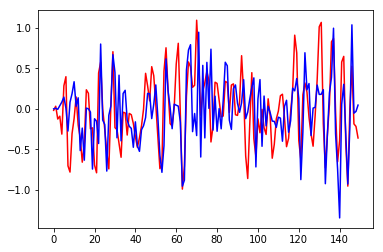

In [61]:
X = gen_dataset1(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Courbe rouge : données simulées")
print("Courbe bleue : valeurs prédites")

ARMA-ONS
time : 99.04


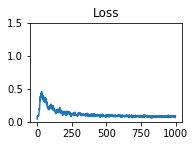

In [62]:
ONS_sim_loss[0], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset1, k=5, q=2, T=1000, iters=200)

ARMA-OGD
time : 66.12


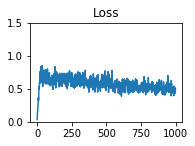

In [111]:
OGD_sim_loss[0], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset1, k=5, q=2, T=1000, iters=200)

ARMA-OGD
time : 176.09


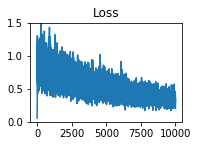

In [84]:
OGD_sim_loss[0], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset1, k=5, q=2, T=10000, iters=50)

(0, 1.5)

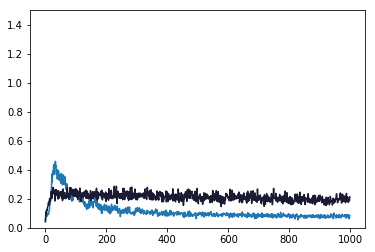

In [64]:
plt.plot(ONS_sim_loss[0].mean(0))
plt.plot(OGD_sim_loss[0].mean(0), color=(0.1, 0.1, 0.2))
plt.ylim(ymax=1.5, ymin=0)

## 2. Deuxième jeu de données

$\alpha_1 = (-0.4, -0.5, 0.4, 0.4, 0.1)$

$\alpha_2 = (0.6, -0.4, 0.4, -0.5, 0.4)$

$\beta = (0.3, -0.2) $

$\varepsilon_t \sim N(0, 0.3)$

$X_t = \sum_{i=1}^a \left[\frac{t}{T}\cdot\alpha_{i}^2 + \left(1-\frac{t}{T}\right)\cdot\alpha_{i}^1 \right]\cdot X_{t-i}  + \sum_{i=1}^b \beta_i\cdot\varepsilon_{t-i} + \varepsilon_t$

Courbe rouge : données simulées
Courbe bleue : valeurs prédites


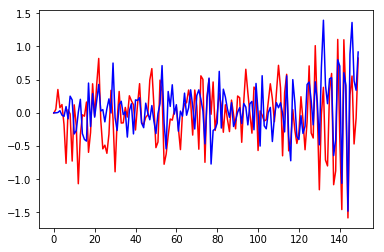

In [65]:
X = gen_dataset2(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Courbe rouge : données simulées")
print("Courbe bleue : valeurs prédites")

ARMA-ONS
time : 98.94


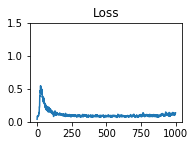

In [66]:
ONS_sim_loss[1], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset2, k=5, q=2, T=1000, iters=200)

ARMA-OGD
time : 66.4


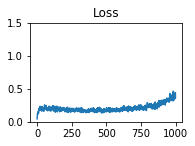

In [67]:
OGD_sim_loss[1], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset2, k=5, q=2, T=1000, iters=200)

(0, 1.5)

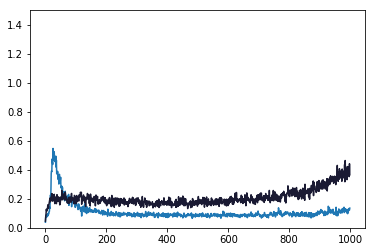

In [68]:
plt.plot(ONS_sim_loss[1].mean(0))
plt.plot(OGD_sim_loss[1].mean(0), color=(0.1, 0.1, 0.2))
plt.ylim(ymax=1.5, ymin=0)

## 3. Troisième jeu de données

$\alpha_1 = (0.6, -0.5, 0.4, -0.4, 0.3)$

$\alpha_2 = (-0.4, -0.5, 0.4, 0.4, 0.1)$

$\beta_1 = (0.3, -0.2) $

$\beta_2 = (-0.3, 0.2) $


$\varepsilon_t \sim N(0, 0.3)$

$X_t = \sum_{i=1}^a \left[\frac{t}{T}\cdot\alpha_{i}^2 + \left(1-\frac{t}{T}\right)\cdot\alpha_{i}^1 \right]\cdot X_{t-i}  + \sum_{i=1}^b \left[\frac{t}{T}\cdot\beta_{i}^2 + \left(1-\frac{t}{T}\right)\cdot\beta_{i}^1 \right]\cdot\varepsilon_{t-i} + \varepsilon_t$

Courbe rouge : données simulées
Courbe bleue : valeurs prédites


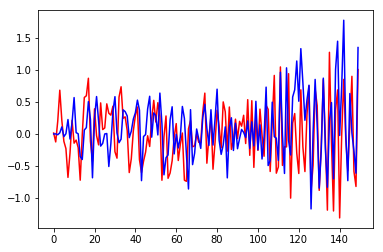

In [69]:
X = gen_dataset3(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Courbe rouge : données simulées")
print("Courbe bleue : valeurs prédites")

ARMA-ONS
time : 98.09


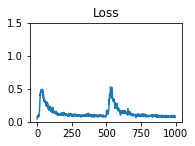

In [70]:
ONS_sim_loss[2], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset3, k=5, q=2, T=1000, iters=200)

ARMA-OGD
time : 65.42


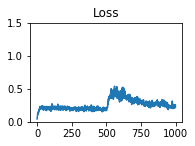

In [71]:
OGD_sim_loss[2], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset3, k=5, q=2, T=1000, iters=200)

(0, 1.5)

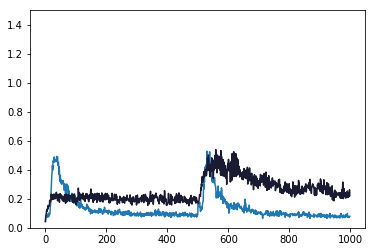

In [72]:
plt.plot(ONS_sim_loss[2].mean(0))
plt.plot(OGD_sim_loss[2].mean(0), color=(0.1, 0.1, 0.2))
plt.ylim(ymax=1.5, ymin=0)

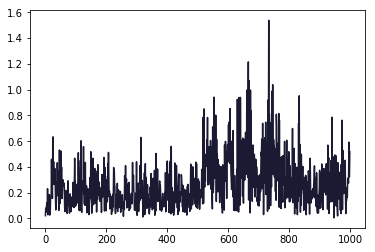

In [98]:
plt.plot(OGD_sim_loss[2][1:6].mean(0), color=(0.1, 0.1, 0.2))

In [92]:
OGD_sim_loss[2].shape

(200, 1000)

## 4. Quatrième jeu de données

$\alpha = (0.11, -0.5)$

$\beta = (0.41, -0.39, -0.685, 0.1) $

$\varepsilon_t \sim N(0, 0.3)$

Courbe rouge : données simulées
Courbe bleue : valeurs prédites


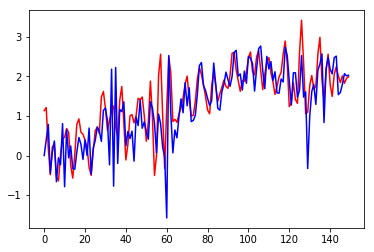

In [73]:
X = gen_dataset4(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Courbe rouge : données simulées")
print("Courbe bleue : valeurs prédites")

ARMA-ONS
time : 282.56


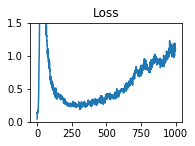

In [86]:
ONS_sim_loss[3], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset4, k=2, q=4, T=1000, iters=400)

ARMA-OGD
time : 92.91


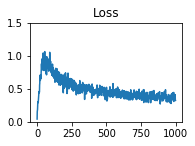

In [84]:
OGD_sim_loss[3], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset4, k=2, q=4, T=1000, iters=200)

(0, 1.5)

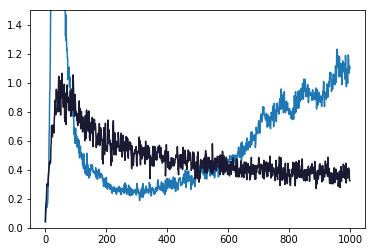

In [87]:
plt.plot(ONS_sim_loss[3].mean(0))
plt.plot(OGD_sim_loss[3].mean(0), color=(0.1, 0.1, 0.2))
plt.ylim(ymax=1.5, ymin=0)

## 5. Cinquième jeu de données

$t \leq 0.5 : \alpha = (-0.4, -0.5, 0.4, 0.4, 0.1)$

$t > 0.5 : \alpha = (0.6, -0.4, 0.4, -0.5, 0.4) $

$\beta = (0.32, -0.2)$

$\varepsilon_t \sim N(0, 0.3)$

Courbe rouge : données simulées
Courbe bleue : valeurs prédites


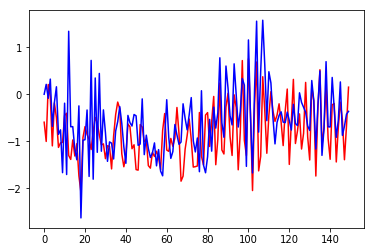

In [77]:
X = gen_dataset5(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Courbe rouge : données simulées")
print("Courbe bleue : valeurs prédites")

ARMA-ONS
time : 100.25


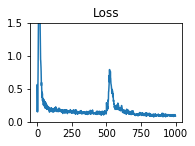

In [78]:
ONS_sim_loss[4], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset5, k=5, q=2, T=1000, iters=200)

ARMA-OGD
time : 66.43


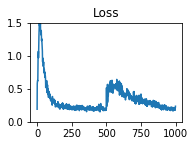

In [79]:
OGD_sim_loss[4], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset5, k=5, q=2, T=1000, iters=200)

(0, 1.5)

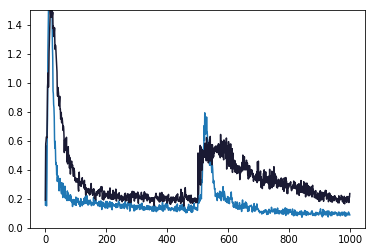

In [80]:
plt.plot(ONS_sim_loss[4].mean(0))
plt.plot(OGD_sim_loss[4].mean(0), color=(0.1, 0.1, 0.2))
plt.ylim(ymax=1.5, ymin=0)

## 6. Sixième jeu de données

$t \neq 0.5 : \alpha_1 = (-0.4, -0.5, 0.4, 0.4, 0.1)$

$t = 0.5 : \alpha_2 = (5, -0.5, 0.4, 0.4, 0.1) $

$\beta = (0.32, -0.2)$

Courbe rouge : données simulées
Courbe bleue : valeurs prédites


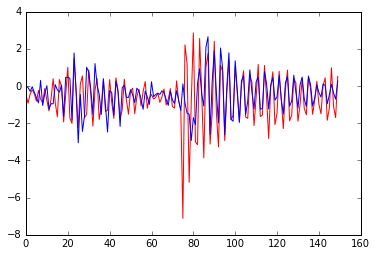

In [15]:
X = gen_dataset6(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Courbe rouge : données simulées")
print("Courbe bleue : valeurs prédites")

ARMA-ONS
time : 98.84


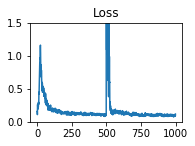

In [58]:
ONS_sim_loss[5], _, ONS_sim_L[5] = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset6, k=5, q=2, T=1000, iters=200)

ARMA-OGD
time : 66.25


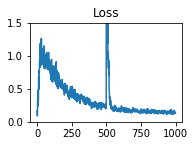

In [59]:
OGD_sim_loss[5], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset6, k=5, q=2, T=1000, iters=200)

(0, 1.5)

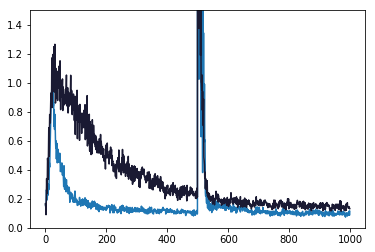

In [60]:
plt.plot(ONS_sim_loss[5].mean(0))
plt.plot(OGD_sim_loss[5].mean(0), color=(0.1, 0.1, 0.2))
plt.ylim(ymax=1.5, ymin=0)

___
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />












ARMA-OGD
time : 143.85


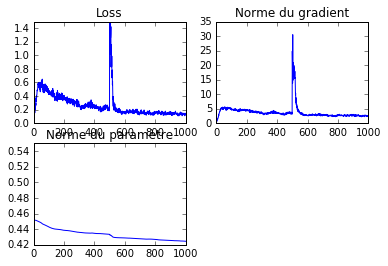

In [8]:
n = 1000
iters = 200
t0 = time.time()
print("ARMA-OGD")

k = 5
q = 2
m = int(np.round(q*np.log(n)))
sim_loss, sim_nabla, sim_L = simulate(gen_dataset6, n, arma_ogd, iters, m, k, q, projection=True)

plt.subplot(221)
moy_loss = sim_loss.mean(axis=0) #gen_errors(loss)
plt.plot(moy_loss)
plt.ylim(ymax=1.5)
plt.title("Loss")

plt.subplot(222)
moy_gradient_norme = sim_nabla.mean(axis=0)
plt.plot(moy_gradient_norme)
plt.title("Norme du gradient")

plt.subplot(223)
moy_parametre_norme = sim_L.mean(axis=0)
plt.plot(moy_parametre_norme)
plt.ylim(ymax=0.55)
plt.title("Norme du paramètre")

print("time : {}".format(round(time.time()-t0, 2)))

## ARMA-RLS

In [91]:
def arma_rls(X, m, k, q, projection=False):
    T = X.shape[0]
    n = k + q
    p = 10 * n

    X = np.matrix(X).T

    theta = (1 / 10**6) * np.matrix(np.ones(n)).T
    P = (1 / 10**6) * np.matrix(np.ones((n, n)))

    Phi = np.matrix(np.ones((n, p)))

    mu_p = np.matrix(np.zeros(T)).T
    X_p = np.matrix(np.zeros(T)).T
    loss = np.matrix(np.zeros(T)).T
    
    # on initialise les premiers bruits
    # pour calculer phi on a besoin des p + n premiers bruits "calculables"
    # Le premier bruit "calculable" est le (n+1)-ième (ce qui correspond au bruit d'indice t0=n)
    t0 = n
    for i in range(p + n):
        mu_p[t0 + i] = X[t0 + i] - np.dot(X[(t0+i-n):(t0+i)].T, theta) # (t0+i-n):(t0+i) s'arrête à t0=i-1

    # les itérations de l'algorithme vont commencer à partir de l'instant d'indice t1 = n+p
    for t1 in range(t0 + n+p, T-1):
        # on initialise mu_p :
        for i in range(p):
            Phi[0:k, i] = - np.flip(X[(t1-k-i):(t1-i)], axis=0) # s'arrête à t1-1-i
            Phi[k:(k+q), i] = - np.flip(mu_p[(t1-q-i):(t1-i)], axis=0)
        P = P + np.dot(Phi, Phi.T)
        theta = theta + np.dot(inv(P), 
                               np.dot(Phi, 
                                      np.flip(X[(t1-p+1):(t1+1)], axis=0) - np.dot(Phi.T, theta) # s'arrête à t1
                                     )
                              )
        X_p[t1] = np.dot(Phi[:, 0].T, theta)
        mu_p[t1] = X[t1] - X_p[t1]
    return np.array(X_p), 0.5*np.array(mu_p)**2, np.array(mu_p), theta


ARMA-RLS


Text(0.5,1,'Norme du gradient')

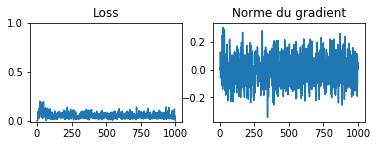

In [92]:
n = 1000
iters = 10

print("ARMA-RLS")

k = 4
q = 2
m = int(np.round(q*np.log(n)))
sim_loss_rls, sim_noize_rls, sim_theta_rls = simulate(gen_dataset1, n, arma_rls, iters, m, k, q)

plt.subplot(221)
moy_loss = sim_loss_rls.mean(axis=0) #gen_errors(loss)
plt.plot(moy_loss)
plt.ylim(ymax=1)
plt.title("Loss")

plt.subplot(222)
moy_noize_norme = sim_noize_rls.mean(axis=0)
plt.plot(moy_noize_norme)
plt.title("Norme du gradient")

#plt.subplot(223)
#moy_parametre_norme = sim_L.mean(axis=0)
#plt.plot(moy_parametre_norme)
#plt.ylim(ymax=0.55)
#plt.title("Norme du paramètre")

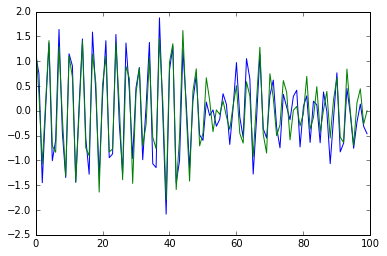

In [187]:
plt.plot(X[9900:10000])
plt.plot(X_p[9900:10000])

(0.0, 1)

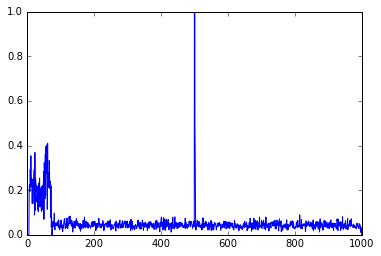

In [231]:
plt.plot(sim_loss_rls.mean(0))
plt.ylim(ymax=1)

# Yule-Walker

In [85]:
def yule_walker(X, m, k, q, projection=True):
    """
    yule walker
    """
    p = m + k
    lag = p + 1
    
    T = X.shape[0]

    X_p = np.zeros(T)
    
    loss_hist = np.zeros(T)
    nabla_norm_hist = np.zeros(T)
    L_hist = np.zeros(T)

    for t in range(20, T):
        X_t = X[:t]
        X_t = X_t - np.mean(X_t)

        
        #-- Estimate phi --
        #------------------
        c = np.correlate(X_t, X_t, 'full')
        mid = len(c)//2
        acov = c[mid:mid+lag]
        acor = acov/acov[0]

        R = linalg.toeplitz(acor[:p])
        r = acor[1:p+1]
        phi = linalg.inv(R).dot(r)
        
        #----- Predict ----
        #------------------
        X_p[t] = np.dot(phi, np.flip(X_t[-p:], 0))
        
        #----- Loss -------
        #------------------
        loss_hist[t] = 0.5 * (X[t]-X_p[t])**2
    return X_p, loss_hist, nabla_norm_hist, L_hist

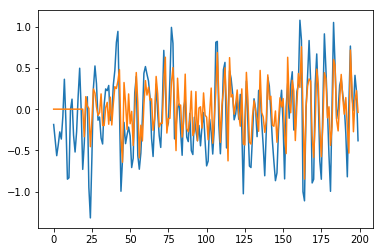

In [71]:
plt.plot(X)
plt.plot(X_p)

Yule-Walker
time : 8.5


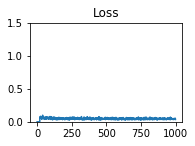

In [87]:
YL_sim_loss[0], _, _ = plot_simulations_results("Yule-Walker", yule_walker, gen_dataset1, k=5, q=2, T=1000, iters=50)